In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания

In [2]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=[3])
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [3]:
start_date = datetime(2020, 3, 3)

data = data[(data['location'] == 'Russia') & (data['date'] >= start_date)]

columns_to_keep = ['date', 'total_cases', 'new_cases']
data = data[columns_to_keep]

data.loc[data['new_cases'] == 0, 'new_cases'] = 1
data['day'] = (data['date'] - start_date).dt.days

data.head()

,date,total_cases,new_cases,day
190772,2020-03-03,3.0,1.0,0
190773,2020-03-04,3.0,1.0,1
190774,2020-03-05,4.0,1.0,2
190775,2020-03-06,13.0,9.0,3
190776,2020-03-07,13.0,1.0,4


In [4]:
train_data = data.iloc[:50]
test_data = data.iloc[50:100] 

In [5]:
def plot(x, ys, labels, title):
    plt.figure(figsize=(16, 8))
    
    for y, label in zip(ys, labels):
        plt.plot(x, y, label=label)

    plt.title(title)
    plt.grid()
    plt.xlabel('Day')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.show()

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


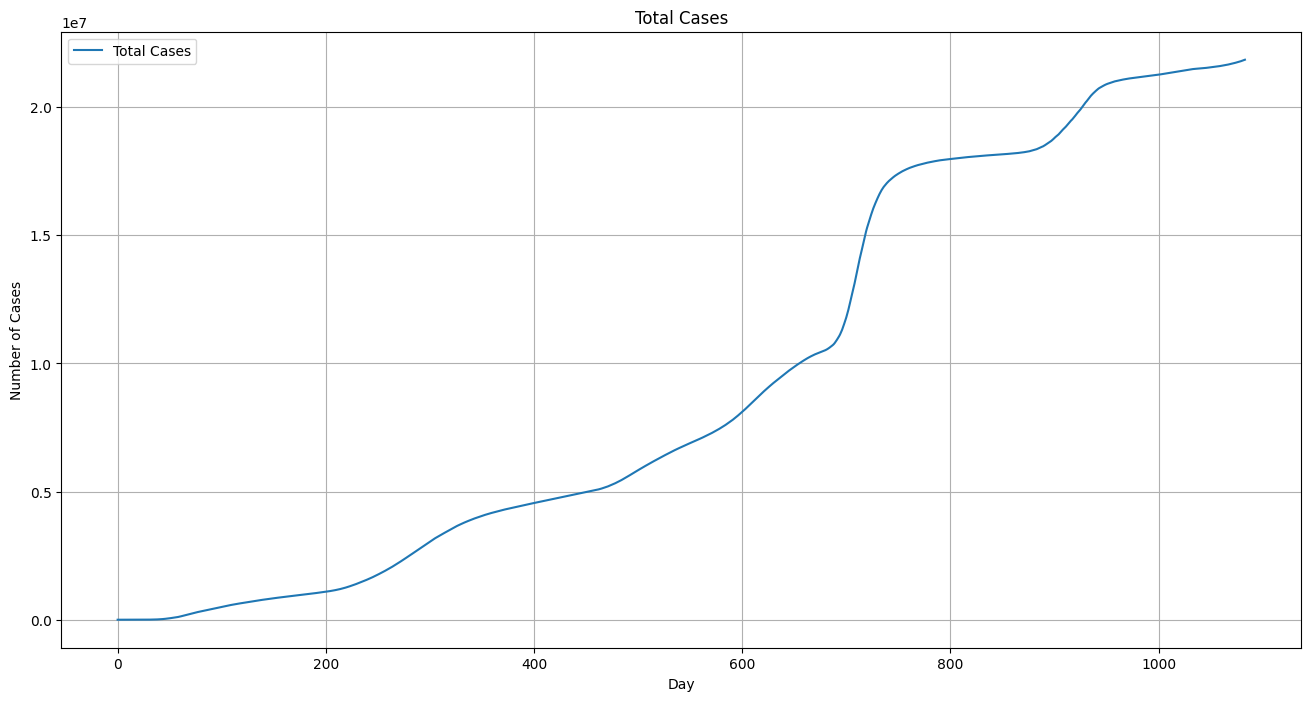

In [6]:
plot(data['day'], [data['total_cases']], ['Total Cases'], 'Total Cases')

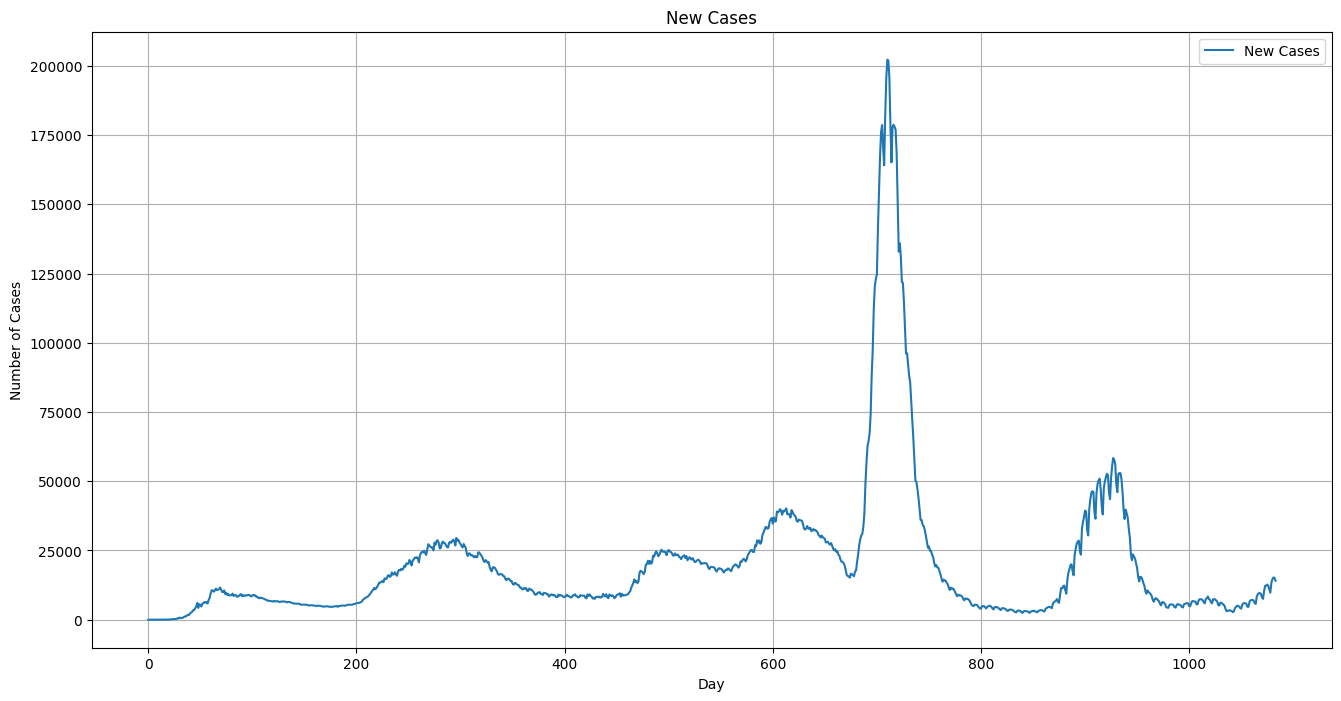

In [7]:
plot(data['day'], [data['new_cases']], ['New Cases'], 'New Cases')

2a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

$$y \sim exp(Wx + b)$$
$$log(y) \sim Wx + b$$

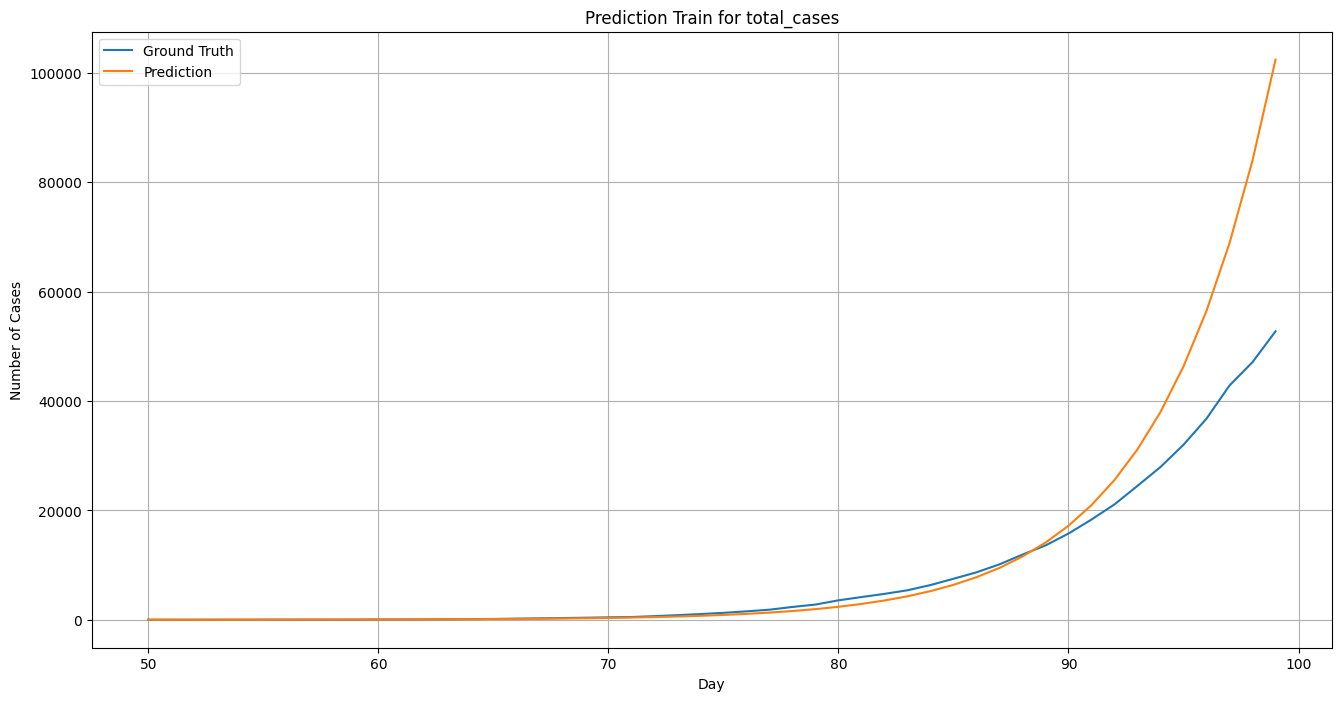

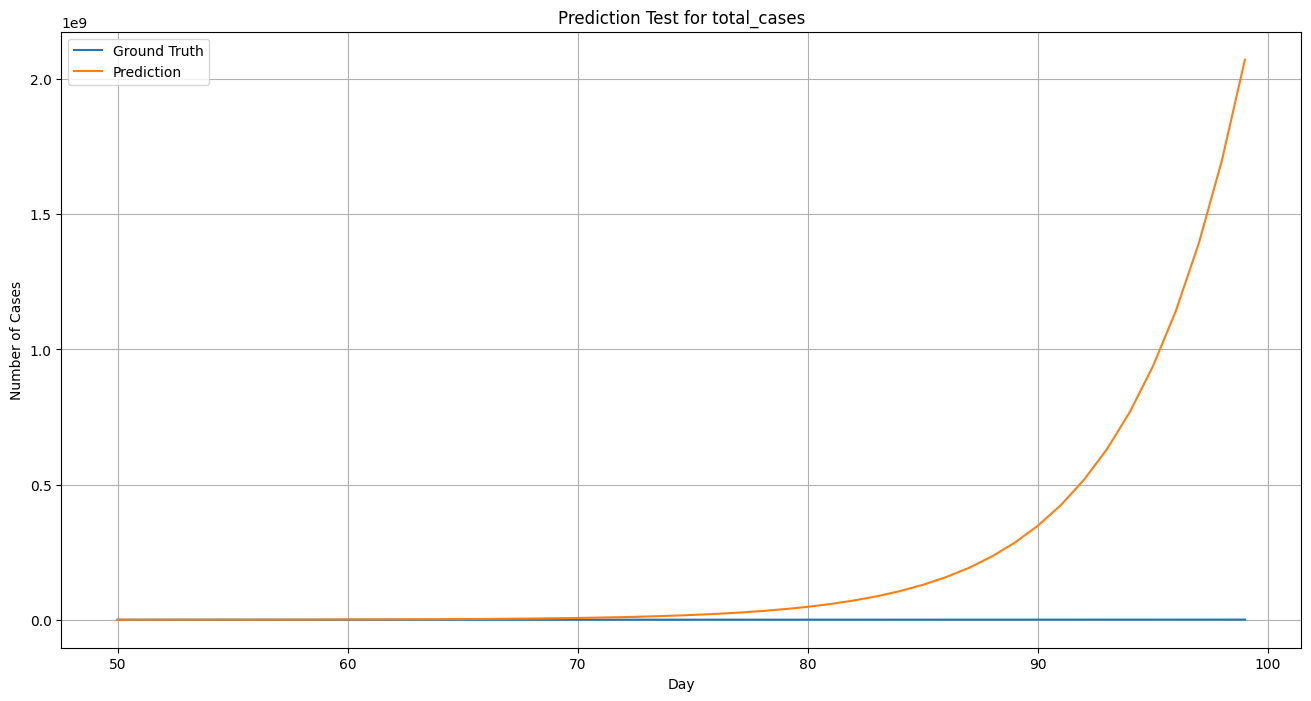

In [8]:
target = 'total_cases'

model = LinearRegression()
model.fit(np.array(train_data['day'].values)[..., np.newaxis], np.log(train_data[target]))

predictions_train = model.predict(np.array(train_data['day'])[..., np.newaxis])
plot(test_data['day'], [train_data[target], np.exp(predictions_train)], ['Ground Truth', 'Prediction'], f'Prediction Train for {target}')

predictions_test = model.predict(np.array(test_data['day'])[..., np.newaxis])
plot(test_data['day'], [test_data[target], np.exp(predictions_test)], ['Ground Truth', 'Prediction'], f'Prediction Test for {target}')



2b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Оценим дисперсию, как среднеквадратичную ошибку, и найдем апостериорное распределение параметров модели по формулам из лекции:
$$
\Sigma_n = (\Sigma_{0}^{-1} + \frac{1}{\sigma^{2}} X^{T} X)^{-1}\\
\mu_n = \Sigma_n (\Sigma_{0}^{-1} \mu_{0}  + \frac{1}{\sigma^{2}} X^{T} \overline{y})\\
$$

In [9]:
sigma_noise = mean_squared_error(np.log(train_data[target]), predictions_train)
print(f'MSE for {target} is {sigma_noise}')

MSE for total_cases is 0.12183046154391232


In [10]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1] + x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [11]:
mu, sigma = np.zeros(2), np.eye(2)
for day in train_data['day']:
    mu, sigma = bayesian_update(mu, sigma, [day],
                                np.log(train_data[target]).iloc[day],
                                sigma_noise)
mu_sigma = (mu, sigma)

print(f'For {target}:\n mean is {mu_sigma[0]}\n variance is\n {mu_sigma[1]}')


For total_cases:
 mean is [1.81969202 0.19832255]
 variance is
 [[ 1.15182466e-03 -3.49037711e-05]
 [-3.49037711e-05  1.42485517e-06]]


2c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

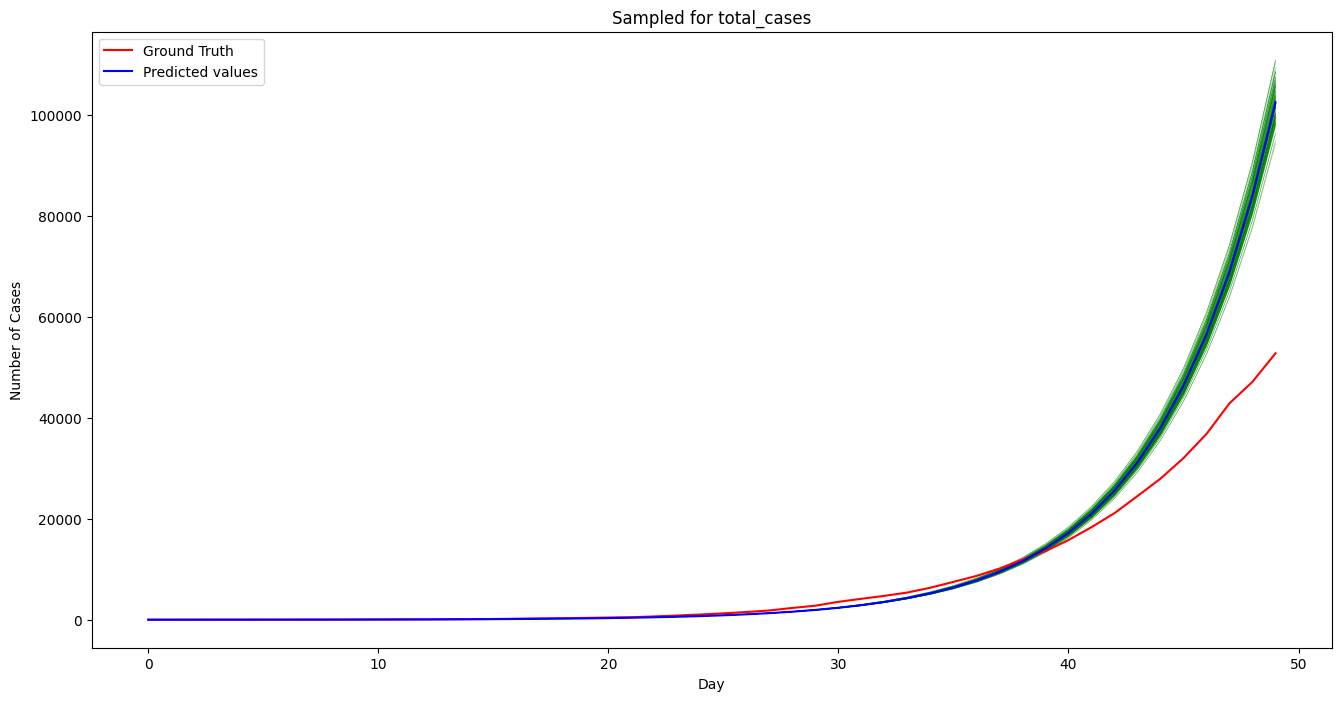

In [12]:
plt.figure(figsize=(16, 8))
weights = np.random.multivariate_normal(mu_sigma[0], mu_sigma[1], 100)
for w in  weights:
    plt.plot(train_data['day'], np.exp([w[0] + w[1] * day for day in train_data['day']]), color='g', linewidth=0.2)

plt.plot(train_data['day'], train_data[target], label='Ground Truth', color='r')

plt.plot(train_data['day'], np.exp(predictions_train), label='Predicted values', color='b')

plt.title(f'Sampled for {target}')
plt.xlabel('Day')
plt.ylabel('Number of Cases')
plt.legend()

plt.show()

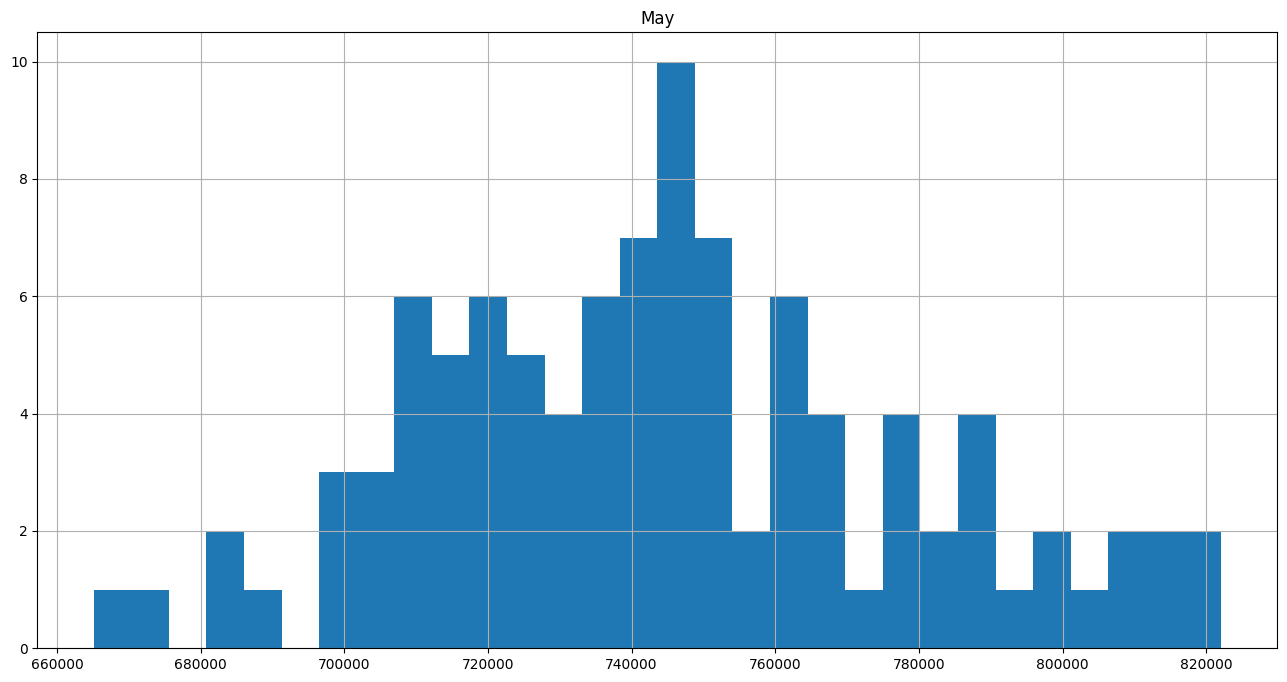

Median:		744501
10-quantile:	706378
90-quantile:	788986
Ground truth:	114431.0


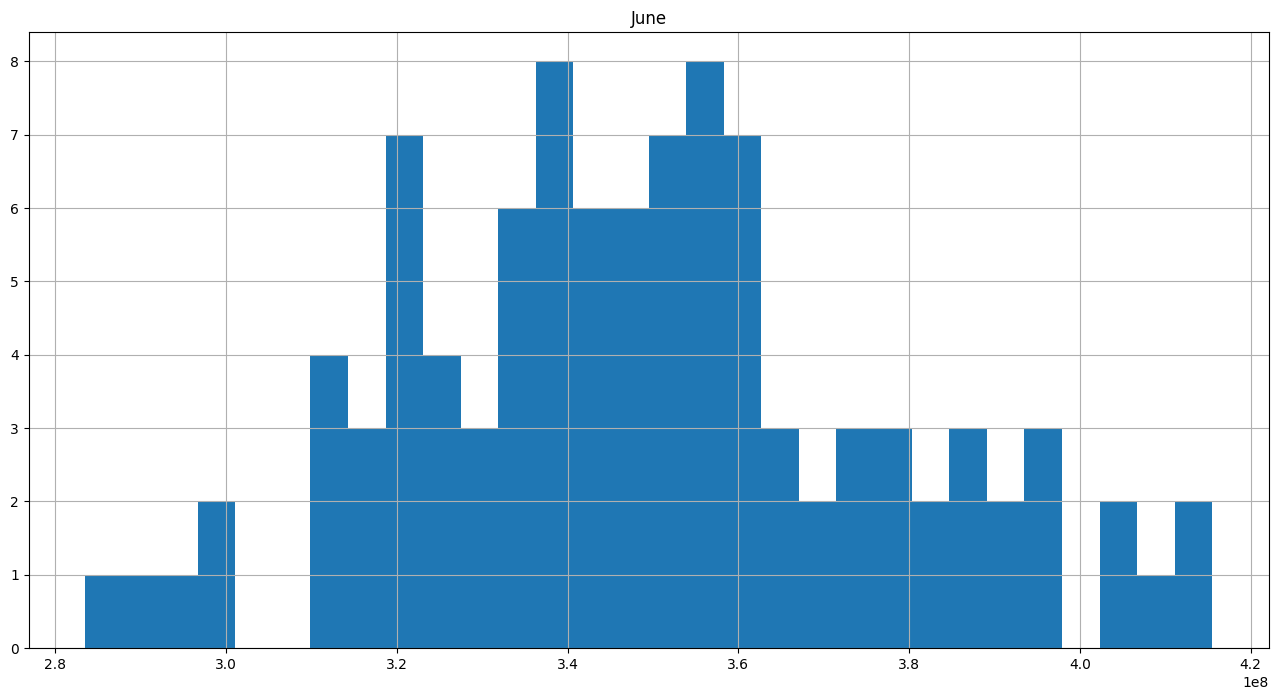

Median:		346916395
10-quantile:	317381603
90-quantile:	389057882
Ground truth:	414328.0


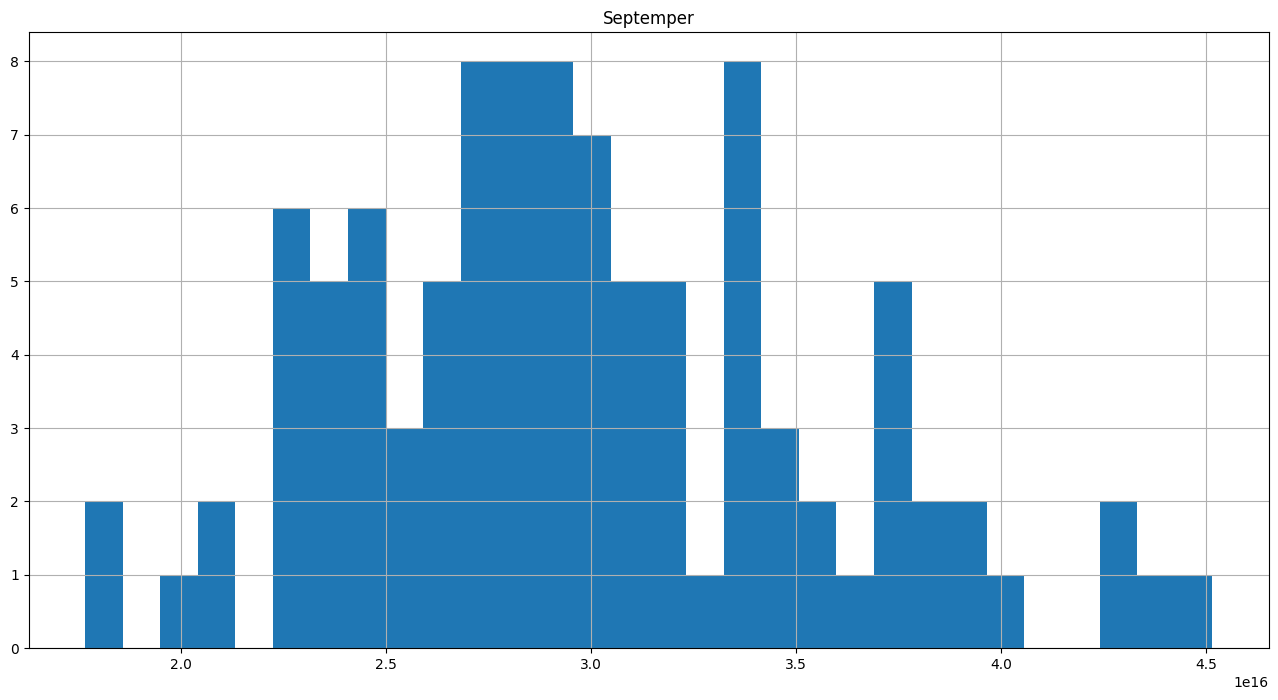

Median:		29118435531616856
10-quantile:	23020722742392088
90-quantile:	37569600983395744
Ground truth:	997072.0


In [13]:
may_first = (datetime(2020, 5, 1) - start_date).days
june_fist = (datetime(2020, 6, 1) - start_date).days
september_first = (datetime(2020, 9, 1) - start_date).days

test_days = {'May': may_first, 'June': june_fist, 'Septemper': september_first}

target = 'total_cases'

for day in test_days:
    predictions = []
    for w in weights:
        predictions.append(np.exp(w[0] + w[1] * test_days[day]))
    plt.figure(figsize=(16, 8))
    plt.hist(predictions, bins=30)
    plt.title(day)
    plt.grid()
    plt.show()

    print(f'Median:\t\t{round(np.quantile(predictions, 0.5))}')
    print(f'10-quantile:\t{round(np.quantile(predictions, 0.1))}')
    print(f'90-quantile:\t{round(np.quantile(predictions, 0.9))}')
    print(f'Ground truth:\t{data.iloc[test_days[day]][target]}')



3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^xe^{-t^2/2}dt$$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.


3a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Если функция:
$$e^{ax^2 + bx +c}$$
будет приближать переменную `new_cases`, то функция:
$$ \int_{-\infty}^xe^{at^2 + bt +c}dt$$
будет приближать переменную `total_cases`.
Добавим квадраты признака (номера дня) и обучим модель на предсказание логарифма переменной `new_cases`.


3b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

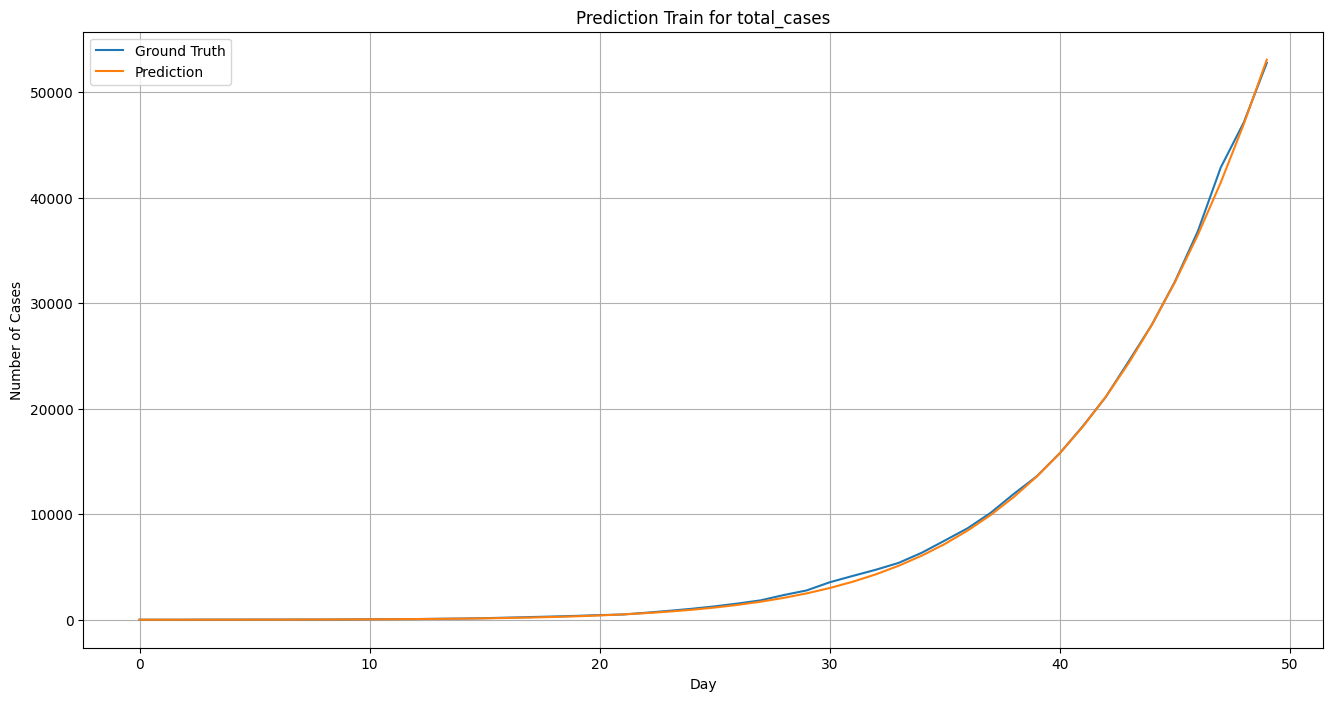

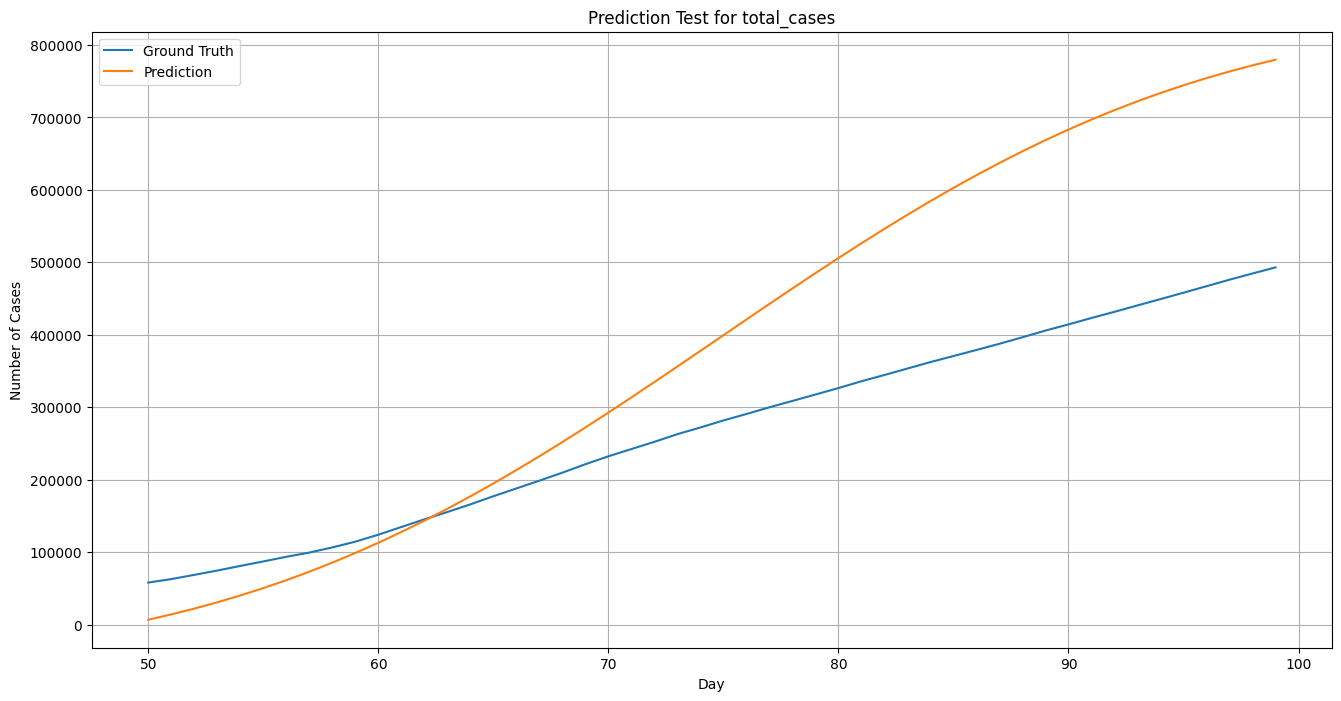

In [14]:
target = 'new_cases'

model = LinearRegression()
model.fit(np.column_stack((train_data['day'].values, train_data['day'].values ** 2)), np.log(train_data[target]))

predictions_train = model.predict(np.column_stack((train_data['day'].values, train_data['day'].values ** 2)))
plot(train_data['day'], [train_data['total_cases'], np.exp(predictions_train).cumsum()], ['Ground Truth', 'Prediction'], f'Prediction Train for total_cases')

predictions_test = model.predict(np.column_stack((test_data['day'].values, test_data['day'].values ** 2)))
plot(test_data['day'], [test_data['total_cases'], np.exp(predictions_test).cumsum()], ['Ground Truth', 'Prediction'], f'Prediction Test for total_cases')

In [15]:
sigma_noise = mean_squared_error(np.log(train_data[target]), predictions_train)
print(f'MSE for {target} is {sigma_noise}')

MSE for new_cases is 0.23928684127005564


In [16]:
mu, sigma = np.zeros(3), np.eye(3)
for day in train_data['day']:
    mu, sigma = bayesian_update(mu, sigma,  [day, day ** 2],
                                np.log(train_data[target]).iloc[day],
                                sigma_noise)
mu_sigma = (mu, sigma)

print(f'For {target}:\n mean is {mu_sigma[0]}\n variance is\n {mu_sigma[1]}')

For new_cases:
 mean is [-0.39460529  0.27545932 -0.00182701]
 variance is
 [[ 9.47860039e-03 -7.65808593e-04  1.28923274e-05]
 [-7.65808593e-04  8.45461037e-05 -1.61426402e-06]
 [ 1.28923274e-05 -1.61426402e-06  3.29619779e-08]]


3c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

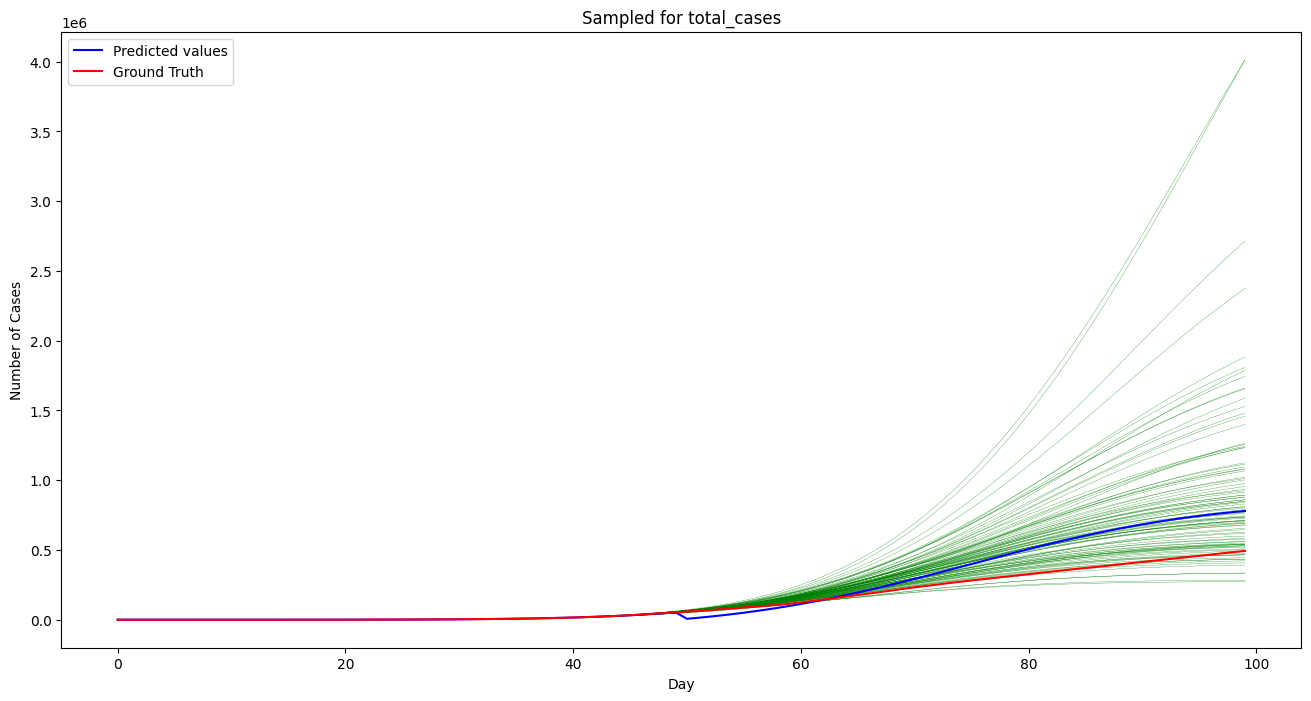

In [17]:
target = 'total_cases'

plt.figure(figsize=(16, 8))
weights = np.random.multivariate_normal(mu_sigma[0], mu_sigma[1], 100)
total_days = pd.concat((train_data['day'], test_data['day']))
for w in weights:
    plt.plot(total_days, np.exp([w[0] + w[1] * day + w[2] * day ** 2 for day in total_days]).cumsum(), color='g', linewidth=0.2)

plt.plot(total_days, np.concatenate((np.exp(predictions_train).cumsum(), np.exp(predictions_test).cumsum())), label='Predicted values', color='b')

plt.plot(total_days, pd.concat((train_data[target], test_data[target])), label='Ground Truth', color='r')

plt.title(f'Sampled for {target}')
plt.xlabel('Day')
plt.ylabel('Number of Cases')
plt.legend()

plt.show()

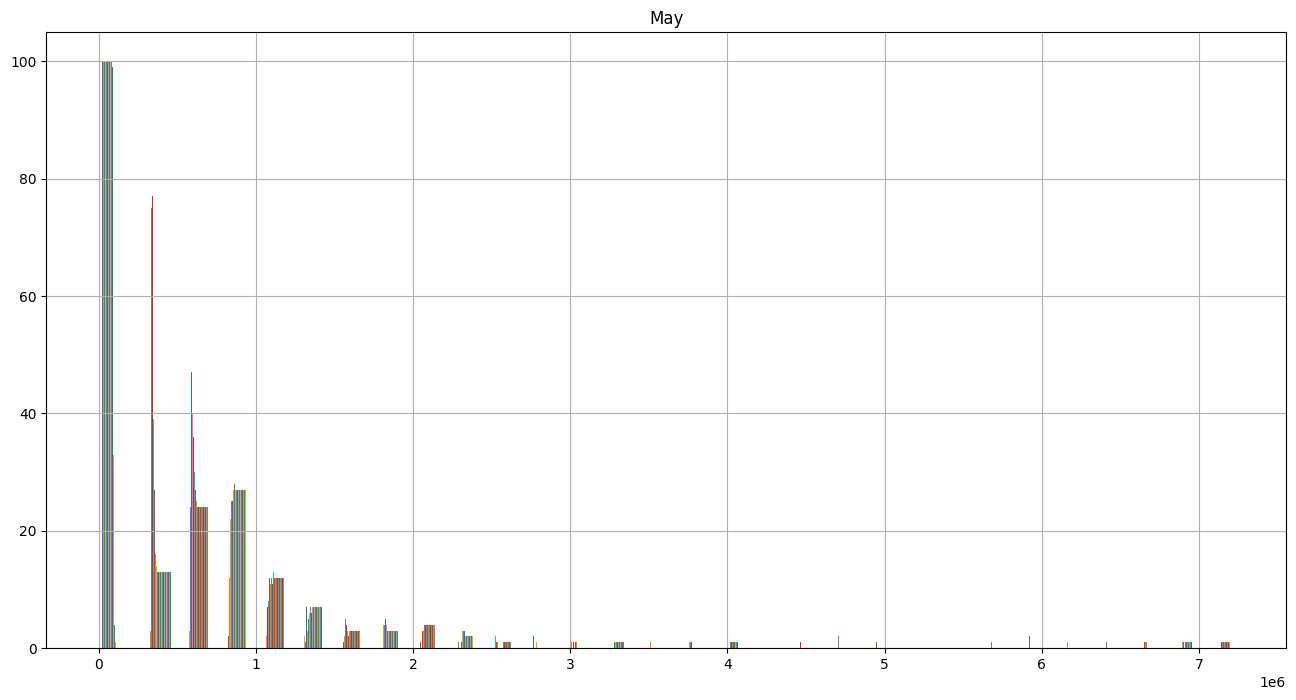

Median:		477329
10-quantile:	259
90-quantile:	1296376
Ground truth:	114431.0


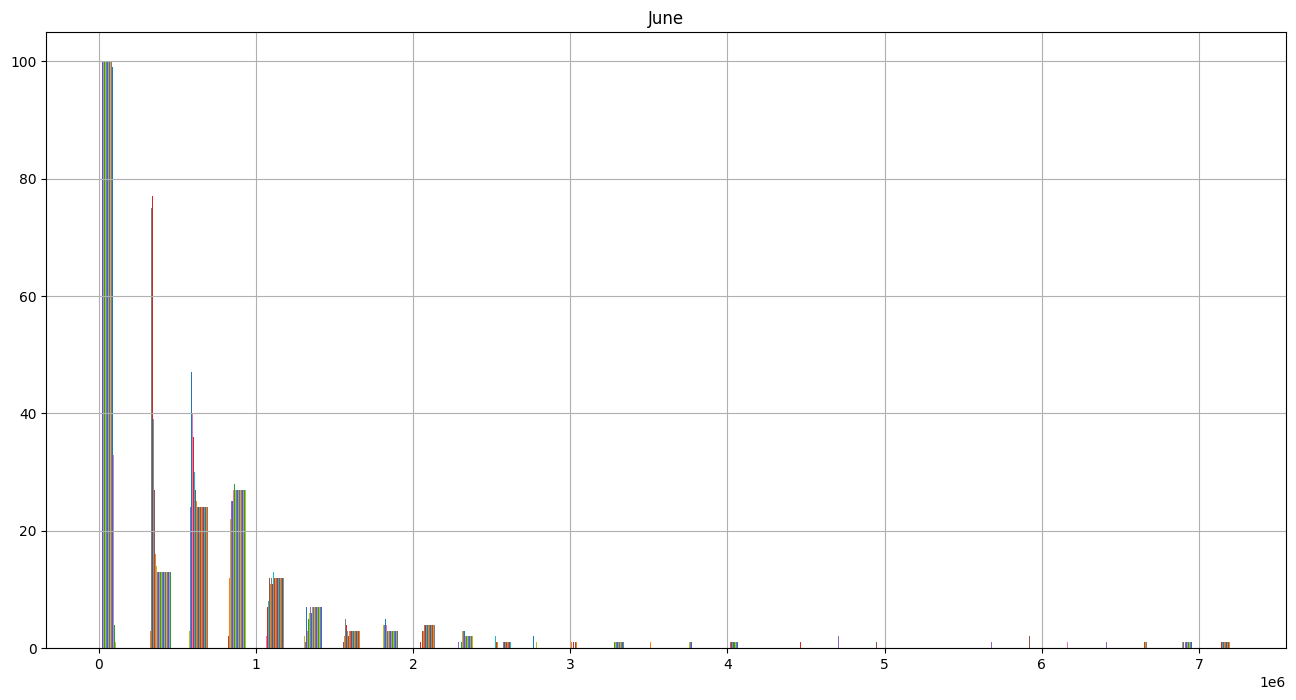

Median:		477329
10-quantile:	259
90-quantile:	1296376
Ground truth:	414328.0


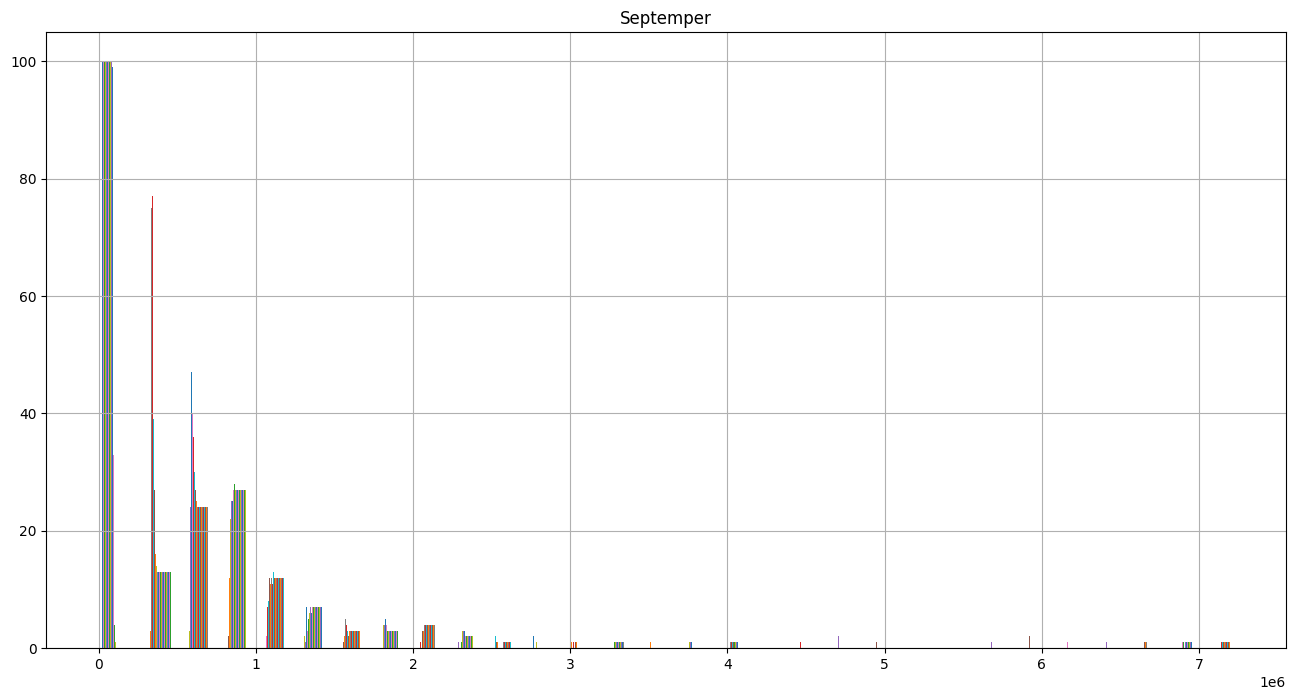

Median:		477329
10-quantile:	259
90-quantile:	1296376
Ground truth:	997072.0


In [21]:
predictions = []
for w in weights:
    predictions.append(np.exp([w[0] + w[1] * day + w[2] * day ** 2 for day in range(september_first + 1)]).cumsum())
predictions = np.array(predictions)

for day in test_days:
    prediction = predictions[:, test_days[day]]

    plt.figure(figsize=(16, 8))
    plt.hist(predictions, bins=30)
    plt.title(day)
    plt.grid()
    plt.show()

    print(f'Median:\t\t{round(np.quantile(predictions, 0.5))}')
    print(f'10-quantile:\t{round(np.quantile(predictions, 0.1))}')
    print(f'90-quantile:\t{round(np.quantile(predictions, 0.9))}')
    print(f'Ground truth:\t{data.iloc[test_days[day]][target]}')